In [39]:
import Pkg
Pkg.activate(".")

# not for the faint of heart!
# Pkg.update()

pkgs = [
"ProgressMeter",
"uCSV",
"DataFrames",
"StatsPlots",
"StatsBase",
"Statistics"
]
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

Pkg.develop(path="../../..")
import Mycelia

  Activating environment at `~/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/Project.toml`
   Resolving package versions...
  No Changes to `~/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/Project.toml`
  No Changes to `~/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `~/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/Project.toml`
  No Changes to `~/workspace/Mycelia/projects/viral-pangenome-discovery/notebooks/Manifest.toml`


In [5]:
PROJECT_BASE = dirname(pwd())

"/home/jovyan/workspace/Mycelia/projects/viral-pangenome-discovery"

In [12]:
SRA_DIR = joinpath(PROJECT_BASE, "data", "SRA")

"/home/jovyan/workspace/Mycelia/projects/viral-pangenome-discovery/data/SRA"

In [13]:
SRRs = filter(x -> occursin(r"^SRR", x), readdir(SRA_DIR))

594-element Vector{String}:
 "SRR6399459"
 "SRR6399460"
 "SRR6399461"
 "SRR6399462"
 "SRR6399463"
 "SRR6399464"
 "SRR6399465"
 "SRR6399466"
 "SRR6399467"
 "SRR6399468"
 "SRR6399469"
 "SRR6399470"
 "SRR6399471"
 ⋮
 "SRR7365474"
 "SRR7365475"
 "SRR7365476"
 "SRR7365477"
 "SRR7365478"
 "SRR7365479"
 "SRR7365480"
 "SRR7365481"
 "SRR7365482"
 "SRR7365483"
 "SRR7365484"
 "SRR7365485"

In [37]:
joint_virus_table = DataFrames.DataFrame()
ProgressMeter.@showprogress for SRR in SRRs
    SRR_dir = joinpath(SRA_DIR, SRR)
    kraken_dir = joinpath(SRR_dir, "kraken")
    kraken_reports = filter(x -> occursin(r"\.kraken-report\.tsv$", x), readdir(kraken_dir))
    @assert length(kraken_reports) == 1
    kraken_report = first(kraken_reports)

    # ranks: (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies.

    kraken_report_header = [
        "percentage_of_fragments_at_or_below_taxon",
        "number_of_fragments_at_or_below_taxon",
        "number_of_fragments_assigned_directly_to_taxon",
        "rank",
        "ncbi_taxonid",
        "scientific_name"
    ]

    data, header = uCSV.read(joinpath(kraken_dir, kraken_report), delim='\t')
    kraken_report_table = DataFrames.DataFrame(data, kraken_report_header)
    kraken_report_table[!, "sample_id"] .= SRR
    for row in DataFrames.eachrow(kraken_report_table[kraken_report_table[!, "ncbi_taxonid"] .== 10239, :])
        push!(joint_virus_table, row)
    end
end
joint_virus_table

Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


Row,percentage_of_fragments_at_or_below_taxon,number_of_fragments_at_or_below_taxon,number_of_fragments_assigned_directly_to_taxon,rank,ncbi_taxonid,scientific_name,sample_id
,Float64,Int64,Int64,String,Int64,String,String
1,0.0,355,0,D,10239,Viruses,SRR6399459
2,0.0,1766,0,D,10239,Viruses,SRR6399460
3,0.0,1509,0,D,10239,Viruses,SRR6399461
4,0.0,2395,0,D,10239,Viruses,SRR6399462
5,0.15,67885,1,D,10239,Viruses,SRR6399463
6,0.0,2836,0,D,10239,Viruses,SRR6399464
7,0.02,7163,0,D,10239,Viruses,SRR6399465
8,0.01,3848,0,D,10239,Viruses,SRR6399466
9,0.05,16953,0,D,10239,Viruses,SRR6399467


In [47]:
StatsBase.describe(filter(x -> !isnan(x), joint_virus_table[!, "percentage_of_fragments_at_or_below_taxon"]))

# Summary Stats:
# Length:         434
# Missing Count:  0
# Mean:           0.076336
# Minimum:        0.000000
# 1st Quartile:   0.000000
# Median:         0.010000
# 3rd Quartile:   0.030000
# Maximum:        7.420000

Summary Stats:
Length:         434
Missing Count:  0
Mean:           0.076336
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.010000
3rd Quartile:   0.030000
Maximum:        7.420000
Type:           Float64


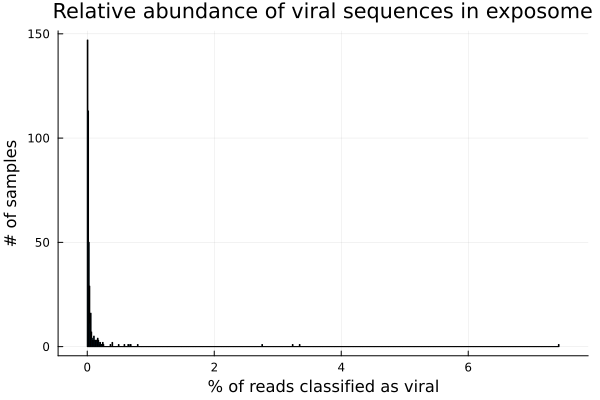

In [50]:
StatsPlots.histogram(
    joint_virus_table[!, "percentage_of_fragments_at_or_below_taxon"],
    ylabel = "# of samples",
    xlabel = "% of reads classified as viral",
    title = "Relative abundance of viral sequences in exposome",
    legend = false
)

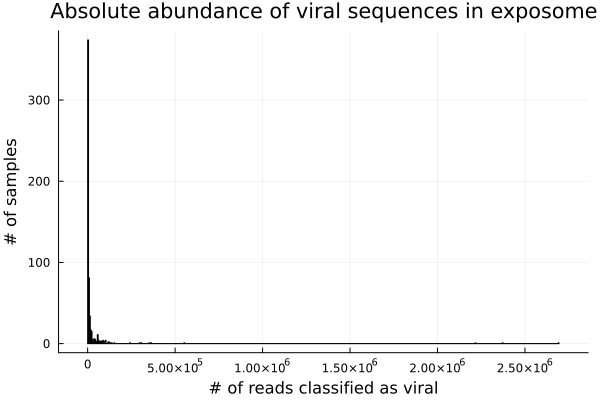

In [56]:
StatsPlots.histogram(
    joint_virus_table[!, "number_of_fragments_at_or_below_taxon"],
    ylabel = "# of samples",
    xlabel = "# of reads classified as viral",
    title = "Absolute abundance of viral sequences in exposome",
    legend = false
)

In [55]:
filtered_joint_virus_table = joint_virus_table[.!isnan.(joint_virus_table[!, "percentage_of_fragments_at_or_below_taxon"]), :]

Row,percentage_of_fragments_at_or_below_taxon,number_of_fragments_at_or_below_taxon,number_of_fragments_assigned_directly_to_taxon,rank,ncbi_taxonid,scientific_name,sample_id
,Float64,Int64,Int64,String,Int64,String,String
1,0.0,355,0,D,10239,Viruses,SRR6399459
2,0.0,1766,0,D,10239,Viruses,SRR6399460
3,0.0,1509,0,D,10239,Viruses,SRR6399461
4,0.0,2395,0,D,10239,Viruses,SRR6399462
5,0.15,67885,1,D,10239,Viruses,SRR6399463
6,0.0,2836,0,D,10239,Viruses,SRR6399464
7,0.02,7163,0,D,10239,Viruses,SRR6399465
8,0.01,3848,0,D,10239,Viruses,SRR6399466
9,0.05,16953,0,D,10239,Viruses,SRR6399467


In [51]:
sort(filtered_joint_virus_table, by=[!, "percentage_of_fragments_at_or_below_taxon"])

594-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN